# Discretize pipes in EPA SWMM to a finer resolution

In [59]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

from urbansurge.swmm_model import SWMM
from urbansurge import file_utils

# Autoreload.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
cfg_dir = Path(r'C:\Users\ay434\Documents\urbansurge\analysis\lab_system')
cfg_fname = 'conduit_discretize_config.yml'
cfg_path = cfg_dir / cfg_fname

swmm = SWMM(cfg_path)
swmm.configure_model()

# Discretize Links.
swmm.discretize_link(1, 10)

# OLD CODE

## Add nodes between nodes.

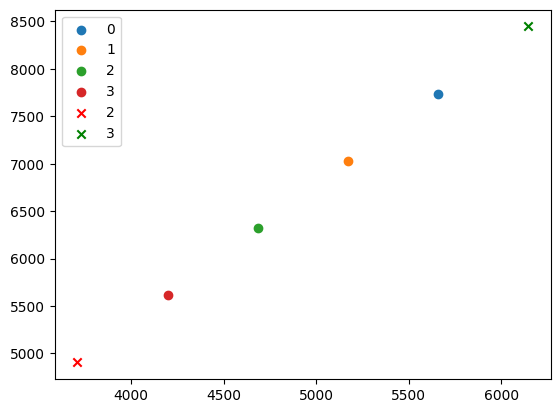

In [103]:
# Node coordinates. 
node_dict = {
    2: np.array([3709.497, 4905.028]),          
    3: np.array([6145.251, 8446.927])  
}

def node_positions(s1, s2, n_segment, n_round=3):
    """
    Create equally spaced coordinates between s1 and s2 that can be connected by n_segment segments.
    """
    u = s2 - s1
    L = np.linalg.norm(u)
    n = u / L  # Unit vector

    c = L / n_segment  # Segment length

    # Generate points between s1 and s2
    I = np.arange(1, n_segment)  # Exclude start and end points
    uc = s1 + np.outer(I, n) * c

    return np.round(uc, n_round)

s1 = node_dict[3]
s2 = node_dict[2]
n_segment = 5
uc = node_positions(s1, s2, n_segment)

for i in range(len(uc)):
    plt.scatter(uc[i,0], uc[i,1], label=i)
plt.scatter(node_dict[2][0], node_dict[2][1], c='r', marker='x', label='2')
plt.scatter(node_dict[3][0], node_dict[3][1], c='g', marker='x', label='3')
plt.legend()

## Invert elevation of new nodes

In [ ]:
node_elev_dict = {
    2: 10,          
    3: 3 
}

def discretize_invert_elevations(h1, h2, n_segment):
    """
    Invert elevations for discretized nodes.

    :param h1: Invert elevation of point 1.
    :param h2: Invert elevation of point 2.
    :param n_segment: Number of segments that the original link was discretized into.

    :return: Invert elevations of discretized nodes.
    """

    return np.linspace(h1, h2, n_segment + 1)[1:-1]

h1 = node_elev_dict[2]
h2 = node_elev_dict[3]
n_segment = 5
invert_elev = discretize_invert_elevations(h1, h2, n_segment)
print(invert_elev)


[8.6 7.2 5.8 4.4]


In [ ]:
def discretize_link(swmm, link_id, n_segment):
    """
    Discretize link into N segments that preserve the original properties of the original link.

    :param swmm: SWMM model object.
    :param link_id: Link to discretize.
    :n_segment: Number of segments to discretize link into.
    """
    # Get upstream and downstream node IDs.
    from_node_id, to_node_id = swmm.get_link_nodes(link_id)
    
    # Get coordinates of the nodes.
    s1 = swmm.get_node_coordinates(from_node_id)
    s2 = swmm.get_node_coordinates(to_node_id)

    # Get discretized node coordinates.
    Dnode_coords = node_positions(s1, s2, n_segment)

    # Get invert elevations of from and to nodes.
    h1 = swmm.get_node_invert_elevation(from_node_id)
    h2 = swmm.get_node_invert_elevation(to_node_id)

    # Invert elevations of discretized nodes.
    Dnode_elev = discretize_invert_elevations(h1, h2, n_segment)

    # Format new nodes.
    #------------------------------------------------
    # Get IDs of existing coordinate nodes.
    exist_node_ids = swmm.get_component_names('COORDINATES')
    exist_node_ids = [int(i) for i in exist_node_ids]
    
    # Create new discretized node ids.
    Dnode_ids = [max(exist_node_ids) + i + 1 for i in range(len(Dnode_coords))]

    # Set surcharge depth to 100 + maximum invert elevation.
    max_elev = max(swmm.get_node_invert_elevation(int(nid)) for nid in exist_node_ids)
    sur_depth = max_elev + 100

    # Add new junctions.
    for i in range(Dnode_coords.shape[0]):
        coord_dict = {'Node': Dnode_ids[i], 'X-Coord': Dnode_coords[i,0], 'Y-Coord': Dnode_coords[i,1]}
        file_utils.add_inp_row(swmm.inp_path, 'COORDINATES', coord_dict)

        junction_dict = {'Name': Dnode_ids[i], 'Elevation': Dnode_elev[i], 'MaxDepth': 0, 'InitDepth': 0, 'SurDepth': sur_depth, 'Aponded': 0}
        file_utils.add_inp_row(swmm.inp_path, 'JUNCTIONS', junction_dict)

    # Format new conduits.
    #------------------------------------------------
    # Existing conduit parameters.
    geom = swmm.get_link_geometry(link_id)
    L = swmm.get_link_length(link_id)
    roughness = swmm.get_link_roughness(link_id)

    # New conduit segment length.
    Lc = L / n_segment

    # Remove the conduit from the inp file.
    file_utils.remove_inp_row(swmm.inp_path, 'CONDUITS', link_id)
    file_utils.remove_inp_row(swmm.inp_path, 'XSECTIONS', link_id)

    # Existing conduit IDs.
    # Get IDs of existing coordinate nodes.
    exist_link_ids = swmm.get_component_names('CONDUITS')
    exist_link_ids = [int(i) for i in exist_link_ids]
    
    # Create new discretized node ids.
    c_ids = [str(max(exist_link_ids) + i + 1) for i in range(n_segment)]

    # Set new CONDUITS AND XSECTIONS sections.
    for i in range(n_segment):
        # From and to nodes.
        if i == 0:
            from_node = from_node_id
            to_node = Dnode_ids[i]
        elif i == n_segment - 1:
            from_node = Dnode_ids[i-1]
            to_node = to_node_id
        else:
            from_node = Dnode_ids[i-1]
            to_node = Dnode_ids[i]

        xsection_dict = {'Link': c_ids[i], 'Shape': 'CIRCULAR', 'Geom1': geom[0], 'Geom2': geom[1], 'Geom3': geom[2], 'Geom4': geom[3], 'Barrels': 1, 'Culvert': ''}
        conduits_dict = {'Name': c_ids[i], 'From Node': from_node, 'To Node': to_node, 'Length': Lc, 'Roughness': roughness, 'InOffset': 0, 'OutOffset': 0, 'InitFlow': 0, 'MaxFlow': 0}

        file_utils.add_inp_row(swmm.inp_path, 'XSECTIONS', xsection_dict)
        file_utils.add_inp_row(swmm.inp_path, 'CONDUITS', conduits_dict)


In [123]:
# Conduit name to discretize.
link_id = 2

cfg_dir = Path(r'C:\Users\ay434\Documents\urbansurge\analysis\lab_system')
cfg_fname = 'conduit_discretize_config.yml'
cfg_path = cfg_dir / cfg_fname

swmm = SWMM(cfg_path)
swmm.configure_model()

swmm.discretize_link(1, 10)
swmm.discretize_link(2, 10)
swmm.discretize_link(3, 10)

Simulation info
Flow Units: CFS
System Units: US
Start Time: 2020-01-01 00:00:00
Start Time: 2020-01-01 06:00:00
Removed Line: 1                3                2                400        0.01       0          0          0          0         

Removed Line: 1                CIRCULAR     1                0          0          0          1                    

Removed Line: 2                1                2                400        0.01       0          0          0          0         

Removed Line: 2                CIRCULAR     1                0          0          0          1                    

Removed Line: 3                2                4                400        0.01       0          0          0          0         

Removed Line: 3                CIRCULAR     1                0          0          0          1                    

